In [1]:
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.signal import argrelextrema
import pickle
import warnings
import kuka_tools as kt
# You can find kuka_tools at https://github.com/robbiemallett/custom_modules/blob/master/kuka_tools.py

/tmp/ipykernel_13011/1142447248.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [60]:
directory = '../data'

ku_ranges = np.array(pd.read_csv('../data/ku_ranges.csv')['ku'])
ka_ranges = np.array(pd.read_csv('../data/ka_ranges.csv')['ka'])
ranges = {'ku':ku_ranges,'ka':ka_ranges}

# First Plot the Normalised Waveforms

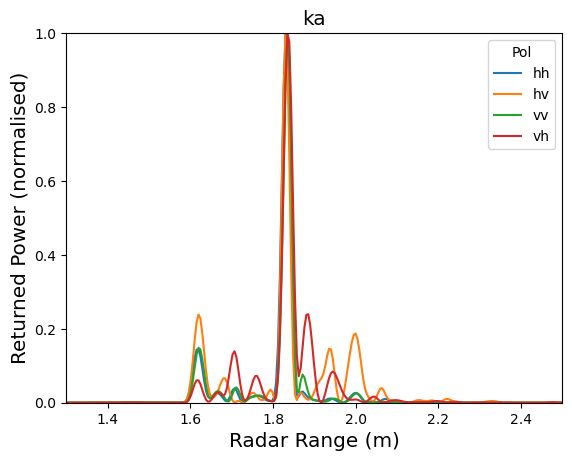

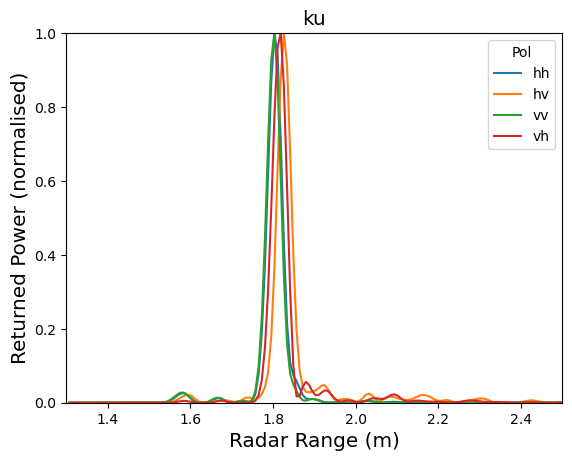

In [7]:
ff = 'Hangar_2023106_single_pit_'

pitno = 1

for freq in ['ka','ku']:

    for pol in ['hh', 'hv','vv','vh']:

        data_dict = pd.read_csv(f'../data/waveforms/{ff}{pitno}_{freq}.csv')

        snow_line = np.array(data_dict[pol]).copy()

        series = np.log10(snow_line)
        # Or redefine to avoid log scale:
        series = snow_line

        r = ranges[freq]

        series[r<1.3] = np.nan
        series[r>2.5] = np.nan
        
        plt.plot(r,series/np.nanmax(series),label=pol)

        # range_vals_for_ylim.append(list(series[(ranges[freq]>1.4)&(ranges[freq]<2.1)]))

        # plt.ylim(0,np.max(range_vals_for_ylim)+0.1*np.max(range_vals_for_ylim))

    plt.ylabel('Returned Power (normalised)',fontsize='x-large')
    plt.xlabel('Radar Range (m)',fontsize='x-large')
    
    plt.xlim(1.3,2.5)
    plt.ylim(0,1)
    plt.legend(title='Pol')

    plt.title(freq,fontsize='x-large')

    plt.show()

### From the above waveforms it's pretty clear that the snow surf is at just over 1.6 m in ka and just under 1.6 m in ku.

# Change the y lims to "zoom in" on these peaks

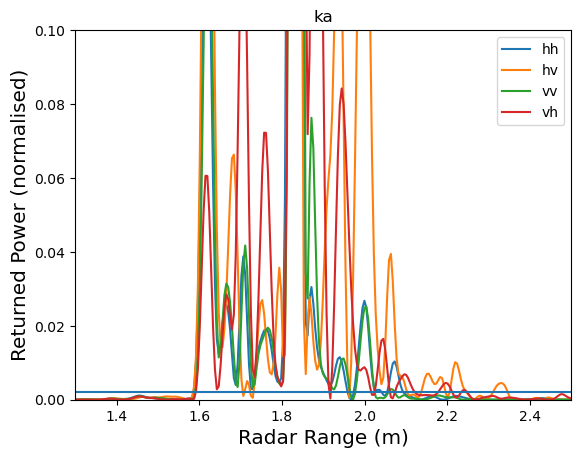

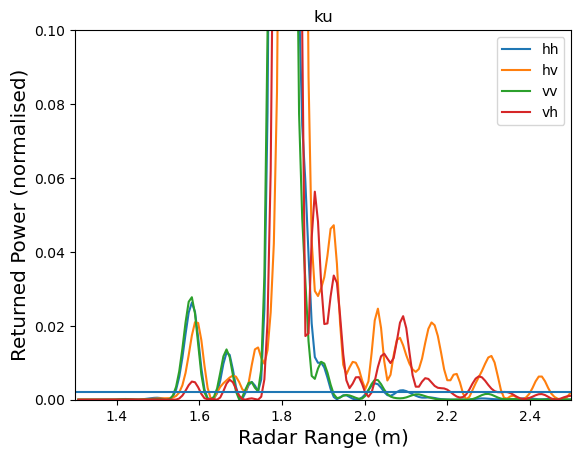

In [12]:
for freq in ['ka','ku']:

    for pol in ['hh', 'hv','vv','vh']:

        data_dict = pd.read_csv(f'../data/waveforms/{ff}{pitno}_{freq}.csv')

        snow_line = np.array(data_dict[pol]).copy()

        series = np.log10(snow_line)
        # Or redefine to avoid log scale:
        series = snow_line

        r = ranges[freq]

        series[r<1.3] = np.nan
        series[r>2.5] = np.nan
        
        plt.plot(r,series/np.nanmax(series),label=pol)

        # range_vals_for_ylim.append(list(series[(ranges[freq]>1.4)&(ranges[freq]<2.1)]))

        # plt.ylim(0,np.max(range_vals_for_ylim)+0.1*np.max(range_vals_for_ylim))

    plt.ylabel('Returned Power (normalised)',fontsize='x-large')
    plt.xlabel('Radar Range (m)',fontsize='x-large')
    
    plt.xlim(1.3,2.5)
    plt.ylim(0,0.1)
    plt.legend()

    thresh = 0.002
    plt.axhline(thresh)

    plt.title(freq)

    plt.show()

## From above plots, it appears that the threshold of 0.002 appears to be right, in that the peaks corresponding to the snow-air interface are the first to exceed it.

ka hh 1.6195751953125002
ka hv 1.6195751953125002
ka vv 1.6195751953125002
ka vh 1.6149975585937502
ku hh 1.5820263671875
ku hv 1.58965576171875
ku vv 1.5820263671875
ku vh 1.5820263671875


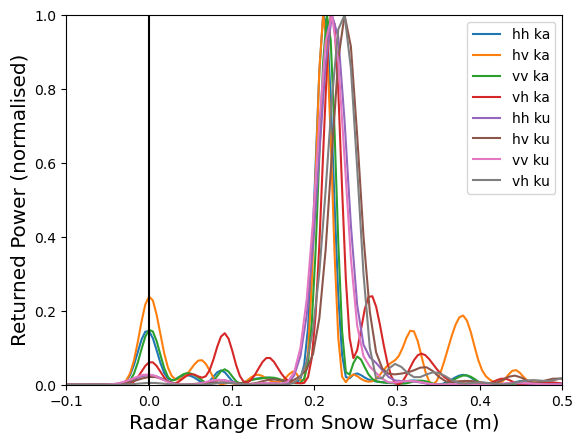

In [57]:
bespoke_ranges = {'ka':{},'ku':{}}

for freq in ['ka','ku']:

    for pol in ['hh', 'hv','vv','vh']:

        data_dict = pd.read_csv(f'../data/waveforms/{ff}{pitno}_{freq}.csv')

        series = np.array(data_dict[pol]).copy()
        r = ranges[freq]

        series[r<1.3] = np.nan
        series[r>2.5] = np.nan
        
        series = series/np.nanmax(series)

        # plt.plot(r,series,label=pol)

        # Find index of array where power first exceeds threshold
        snow_surf_ind_vv = np.argwhere(series>thresh)[0][0] 
        # Make array of indices corresponding to power peaks
        snow_local_maxima_inds_vv = argrelextrema(series, np.greater)
        # Turn that array into *differences* between peaks and index where power first exceeds thresh
        ind_diff = snow_local_maxima_inds_vv[0]-snow_surf_ind_vv
        # Consider only peaks to the right of where the power first exceeds thresh
        max_inds_to_consider = snow_local_maxima_inds_vv[0][ind_diff>0]
        # Find index nearest peak to the right of where power first exceeds thresh
        snow_surface_ind_vv = max_inds_to_consider[np.argmin(ind_diff[ind_diff>0])]
        # Find the range corresponding to the index of the first peak
        range_first_peak = r[snow_surface_ind_vv]

        print(freq,pol,range_first_peak)
        # Save out a bespkoke range index
        bespoke_ranges[freq][pol] = r-range_first_peak

        plt.plot(r-range_first_peak,series,label=f'{pol} {freq}')

plt.ylabel('Returned Power (normalised)',fontsize='x-large')
plt.xlabel('Radar Range From Snow Surface (m)',fontsize='x-large')

# plt.xlim(1.3,2.5)
plt.xlim(-0.1,0.5)
plt.ylim(0,1)
plt.legend()

plt.axvline(0,color='k')

plt.show()

In [59]:
for pol in ['ka','ku']:

    bespoke = pd.DataFrame(bespoke_ranges[pol])

    bespoke.to_csv(f'../data/bespoke_ranges/6thOct_{pol}.csv')